## Для предсказания типа опоры будем использовать только нормализованные углы

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import plotly.plotly as py
import plotly.graph_objs as go
pd.options.mode.chained_assignment = None
from sklearn.externals import joblib
import copy

In [2]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [3]:
os.chdir("../run/")

from utils import CorrelatedRemoval

Load data

In [4]:
data = pd.read_csv('../output/preprocessed_data.csv', index_col=0)
data.reset_index(drop=True, inplace=True)

In [5]:
data.head()

,head_motion_0,head_motion_1,head_motion_2,lfemur_motion_0,lfemur_motion_1,lfemur_motion_2,lfoot_motion_0,lfoot_motion_1,lhand_motion_0,lhand_motion_1,...,upperneck_norm_angle_0,upperneck_norm_angle_1,upperneck_norm_angle_2,amc_path,frame,heel_strike_l,heel_strike_r,support,toe_off_l,toe_off_r
0,1.79557,1.148945,-1.011070,-28.0310,-0.865269,-22.3005,-8.18919,14.3282,-21.3185,21.9844,...,-0.086489,0.257979,0.019490,02_01.amc,11,1,0,ds,0,1
1,1.74626,1.148945,-0.771107,-28.0007,-0.715941,-22.3575,-8.01088,13.4488,-21.2367,22.5867,...,-0.095032,0.257979,0.022170,02_01.amc,12,1,0,ds,0,1
2,1.57093,1.148945,-0.442091,-27.7673,-0.722927,-23.2709,-7.96696,12.6847,-21.6456,23.6679,...,-0.103602,0.254352,0.012141,02_01.amc,13,0,0,ds,0,1
3,1.40889,1.148945,-0.278815,-27.3797,-0.546801,-24.4309,-8.25455,12.1527,-21.7629,23.8315,...,-0.108770,0.251613,-0.004768,02_01.amc,14,0,0,ds,0,1
4,1.34171,1.148945,-0.134220,-26.9492,-0.427832,-25.0387,-8.66092,11.8686,-21.2583,22.8057,...,-0.112052,0.246911,-0.015451,02_01.amc,15,0,0,ds,0,1


Select predictors

In [33]:
id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r']

In [7]:
lower_half_bones_minus_toes = ['root', 'femur', 'hipjoint', 'tibia', 'foot']

In [8]:
predictors = []
for col in data.columns.tolist():
    for bone in lower_half_bones_minus_toes:
        if (bone in col) & ('norm_angle' in col):
            predictors.append(col)

In [9]:
predictors

['lfemur_norm_angle_0',
 'lfemur_norm_angle_1',
 'lfemur_norm_angle_2',
 'lfoot_norm_angle_0',
 'lfoot_norm_angle_1',
 'lfoot_norm_angle_2',
 'ltibia_norm_angle_0',
 'ltibia_norm_angle_1',
 'ltibia_norm_angle_2',
 'rfemur_norm_angle_0',
 'rfemur_norm_angle_1',
 'rfemur_norm_angle_2',
 'rfoot_norm_angle_0',
 'rfoot_norm_angle_1',
 'rfoot_norm_angle_2',
 'rtibia_norm_angle_0',
 'rtibia_norm_angle_1',
 'rtibia_norm_angle_2']

In [10]:
len(predictors)

18

In [11]:
all_cols = copy.deepcopy(predictors)
all_cols.extend(id_target_cols)

In [12]:
data = data[all_cols]

Удалим коррелирующие признаки

Попробуем два критерия выбора

In [13]:
correm_mi = CorrelatedRemoval(X=data[predictors], y=data['support'], method_xy='mutual_info_classif')

In [14]:
correm_mi.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [15]:
pr_mi = list(set(predictors) - set(correm_mi.all_corr_feats))

In [16]:
len(pr_mi)

9

In [17]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_mi = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=data[pr_mi], y=data['support'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s finished


In [18]:
correm_f = CorrelatedRemoval(X=data[predictors], y=data['support'], method_xy='f_classif')

In [19]:
correm_f.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [20]:
pr_f = list(set(predictors) - set(correm_f.all_corr_feats))

In [29]:
len(pr_f)

9

In [22]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_f = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=data[pr_f], y=data['support'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


In [23]:
print("Mean Kappa for mutual_inf: {}".format(np.mean(kappa_score_mi)))
print("Std Kappa for mutual_inf: {}".format(np.std(kappa_score_mi)))

print("Mean Kappa for f_classif: {}".format(np.mean(kappa_score_f)))
print("Std Kappa for f_classif: {}".format(np.std(kappa_score_f)))

Mean Kappa for mutual_inf: 0.6691190455456756
Std Kappa for mutual_inf: 0.11658011204900258
Mean Kappa for f_classif: 0.7034601876346527
Std Kappa for f_classif: 0.11683211286554396


Будем использовать критерий f_classif

In [34]:
final_all_cols = copy.deepcopy(id_target_cols)
final_all_cols.extend(pr_f)

df_data = data[final_all_cols]
df_data.to_csv('../output/support_half_toes_norm_data.csv')

In [35]:
scores_dict = {}

In [40]:
models = {
    'lr': LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147),
    'rf': RandomForestClassifier(class_weight="balanced", max_depth=6, n_estimators=500, random_state=147),
    'lda': LinearDiscriminantAnalysis(),
    'qda': QuadraticDiscriminantAnalysis(),
    'knn': KNeighborsClassifier(n_neighbors=10),
    'gb': GradientBoostingClassifier(n_estimators=100, max_depth=5)
}

for name, model in tqdm.tqdm_notebook(models.items()):
    model_pipe = Pipeline([
        ('std_sc', StandardScaler()),
        ('model', model)  
    ])

    sc = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                    scoring=make_scorer(cohen_kappa_score), 
                    X=df_data[pr_f].values, y=df_data['support'].values)
    scores_dict[name] = sc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [41]:
scores_dict

{'gb': array([ 0.84655929,  0.88021046,  0.94086474,  0.9295089 ,  0.88994101]),
 'knn': array([ 0.79123499,  0.82174898,  0.91180729,  0.91479867,  0.86758793]),
 'lda': array([ 0.59884979,  0.72299209,  0.79780777,  0.75319203,  0.56615723]),
 'lr': array([ 0.70996252,  0.6808203 ,  0.83535886,  0.79322158,  0.49793768]),
 'qda': array([ 0.73423581,  0.80099578,  0.79435417,  0.79049447,  0.74834195]),
 'rf': array([ 0.8283321 ,  0.8839485 ,  0.92793323,  0.89922535,  0.82002652])}

Mean Kappa score for lda is : 0.6877997814790173
Mean Kappa score for knn is : 0.8614355722233344
Mean Kappa score for lr is : 0.7034601876346527
Mean Kappa score for rf is : 0.8718931406631057
Mean Kappa score for qda is : 0.7736844386134079
Mean Kappa score for gb is : 0.897416879647602


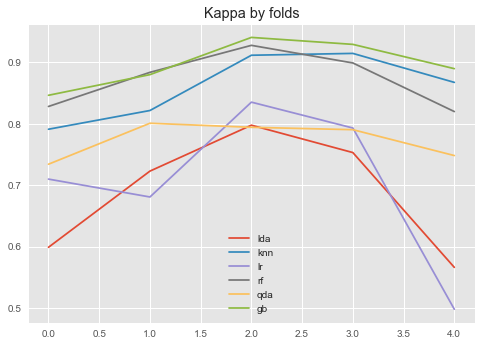

In [42]:
for name, scores in scores_dict.items():
    plt.plot(scores, label=name)
    print("Mean Kappa score for {} is : {}".format(name, np.mean(scores)))
plt.legend(loc=0)
plt.title('Kappa by folds');

In [43]:
skf = StratifiedShuffleSplit(test_size=0.3, random_state=147, n_splits=1)
for train_index, test_index in skf.split(X=df_data[pr_f], y=df_data['support'].values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df_data.loc[train_index, pr_f], df_data.loc[test_index, pr_f]
    y_train, y_test = df_data.loc[train_index, 'support'], df_data.loc[test_index, 'support']

TRAIN: [ 9939 12539  5481 ...,   207 14690  7938] TEST: [ 6921 17002 23234 ..., 18633  2360 23462]


In [44]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5))  
])

In [45]:
model_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('std_sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [46]:
proba = model_pipe.predict_proba(X_test)

pred = model_pipe.predict(X_test)

In [47]:
accuracy_score(y_pred=pred, y_true=y_test)

0.96084256008641644

In [48]:
cohen_kappa_score(y1=y_test, y2=pred)

0.93948870443043642

In [49]:
print(classification_report(y_pred=pred, y_true=y_test))

             precision    recall  f1-score   support

         ds       0.96      0.95      0.96      3329
        lss       0.97      0.97      0.97      2047
        rss       0.95      0.97      0.96      2030

avg / total       0.96      0.96      0.96      7406



In [50]:
gb = model_pipe.steps[-1][1]

feat_imp = pd.DataFrame([X_train.columns.tolist(), gb.feature_importances_.tolist()]).T
feat_imp.columns = ['feat', 'imp']
feat_imp.sort_values('imp', ascending=False, inplace=True)

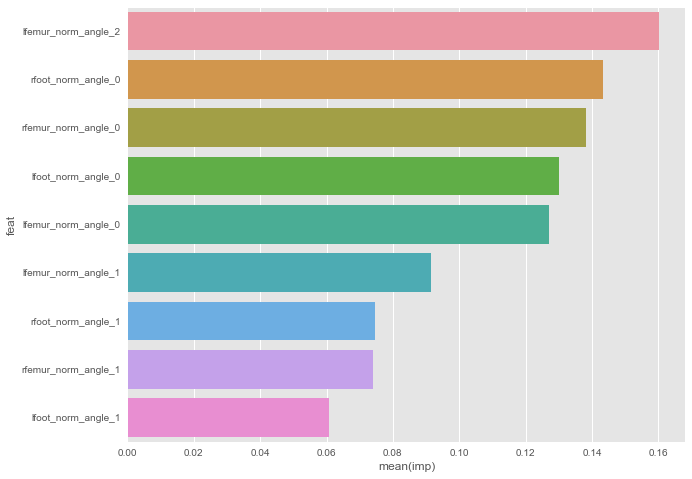

In [51]:
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp, y='feat', x='imp', orient='h');

In [52]:
joblib.dump(filename='../output/toes_norm.pkl', value=model_pipe)

['../output/toes_norm.pkl']